## Connected components

For all interactomes:
* Number of connected components
* Size of the largest connected component
* Relative size of the largest connected component
* Average size of the connected components
* Size of the smallest component
* Number of isolated nodes

For all pathways:
- Sizes of connected components for all pathways

In [86]:
import bisect

import networkx as nx
import pandas as pd
import seaborn
import seaborn as sns

import config
from config import GRAPHS_PATH
from lib.networks import get_interactomes

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


In [87]:
interactomes = get_interactomes(GRAPHS_PATH)

In [88]:
from lib.networks import get_multiindex
import itertools


def getTuples(i):
    sizes = [len(c) / i.number_of_nodes() for c in sorted(nx.connected_components(i), key=len, reverse=True)]
    d = [(i.graph["method"], i.graph["level"], s) for s in sizes]
    return d


tuples = [getTuples(i) for i in interactomes]
data = list(itertools.chain.from_iterable(tuples))
data
df_cc = pd.DataFrame(data, columns=['Small Molecules', 'Entity Level', 'Size'])
df_cc

,Small Molecules,Entity Level,Size
0,no_sm,genes,0.81
1,no_sm,genes,0.01
2,no_sm,genes,0.00
3,no_sm,genes,0.00
4,no_sm,genes,0.00
...,...,...,...
13277,with_unique_sm,proteoforms,0.00
13278,with_unique_sm,proteoforms,0.00
13279,with_unique_sm,proteoforms,0.00
13280,with_unique_sm,proteoforms,0.00


In [89]:
# Number of connected components
# Size of the largest connected component
# Relative size of the largest connected component
# Average size of the connected components
# Size of the smallest component
# Number of isolated nodes

def getTuples(i):
    ccs_sizes = [len(c) for c in sorted(nx.connected_components(i), key=len, reverse=False)]
    num_ccs = len(ccs_sizes)

    return (
        i.graph["method"],
        i.graph["level"],
        num_ccs,
        ccs_sizes[-1],
        ccs_sizes[-1] / i.number_of_nodes(),
        sum(ccs_sizes) / len(ccs_sizes),
        ccs_sizes[0],
        0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes))
    )


data = [getTuples(i) for i in interactomes]
columns = [
    'Method',
    'Level',
    'Number of connected components',
    'Size of largest connected component',
    'Relative size of largest connected component',
    'Average size of connected components',
    "Size of smallest connected component",
    "Number of isolated nodes"
]
df_interactomes = pd.DataFrame.from_records(data, columns=columns, index=get_multiindex())
df_interactomes[columns[2:]]

Number of connected components  \
Small Molecules          Entity Level                                   
Not Included             genes                                   1773   
                         proteins                                1774   
                         proteoforms                             1821   
Included                 genes                                    195   
                         proteins                                 195   
                         proteoforms                              205   
Reaction-Unique Included genes                                   2427   
                         proteins                                2427   
                         proteoforms                             2465   

                                       Size of largest connected component  \
Small Molecules          Entity Level                                        
Not Included             genes                                        8869   
                         proteins                                     8966   
                         proteoforms                                 11984   
Included                 genes                                       12692   
                         proteins                                    12790   
                         proteoforms                                 15962   
Reaction-Unique Included genes                                       28696   
                         proteins                                    28793   
                         proteoforms                                 31644   

                                       Relative size of largest connected component  \
Small Molecules          Entity Level                                                 
Not Included             genes                                                 0.81   
                         proteins                                              0.81   
                         proteoforms                                           0.84   
Included                 genes                                                 0.98   
                         proteins                                              0.98   
                         proteoforms                                           0.98   
Reaction-Unique Included genes                                                 0.73   
                         proteins                                              0.73   
                         proteoforms                                           0.75   

                                       Average size of connected components  \
Small Molecules          Entity Level                                         
Not Included             genes                                         6.19   
                         proteins                                      6.24   
                         proteoforms                                   7.85   
Included                 genes                                        66.32   
                         proteins                                     66.83   
                         proteoforms                                  79.32   
Reaction-Unique Included genes                                        16.10   
                         proteins                                     16.14   
                         proteoforms                                  17.20   

                                       Size of smallest connected component  \
Small Molecules          Entity Level                                         
Not Included             genes                                            1   
                         proteins                                         1   
                         proteoforms                                      1   
Included                 genes                                            1   
                         proteins                                         

In [90]:
from pathlib import Path
from config import METHODS, PATHWAY_GRAPHS_PATH
from config import LEVELS
from lib.networks import get_json_filename, create_pathway_interaction_network, read_graph, replace_methods
from lib.graph_database_access import get_pathways

columns_for_pathways = [
    'Pathway',
    'Small Molecules',
    'Entity Level',
    'Relative size of largest connected component',
    'Average relative size of connected components',
    'Relative Size of smallest connected component',
    'Relative Number of isolated nodes'
]


def get_pathway_tuples(pathway, pathway_graph):
    ccs_sizes = [len(cc) for cc in sorted(nx.connected_components(pathway_graph), key=len, reverse=False)]
    rel_ccs_sizes = [size / pathway_graph.number_of_nodes() for size in ccs_sizes]

    return (
        pathway,
        pathway_graph.graph["method"],
        pathway_graph.graph["level"],
        rel_ccs_sizes[-1],
        sum(rel_ccs_sizes) / len(rel_ccs_sizes),
        rel_ccs_sizes[0],
        0 if ccs_sizes[0] > 1 else bisect.bisect_left(ccs_sizes, 2, lo=0, hi=len(ccs_sizes)) / len(ccs_sizes)
    )


data_pathways = []
for pathway in get_pathways()["stId"]:
    for method in METHODS:
        for level in LEVELS:
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            if not Path(filename).exists():
                create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
            G = read_graph(filename)
            if G.number_of_nodes() > 0:
                data_pathways.append(get_pathway_tuples(pathway, G))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns_for_pathways)
df_pathways

,Pathway,Small Molecules,Entity Level,Relative size of largest connected component,Average relative size of connected components,Relative Size of smallest connected component,Relative Number of isolated nodes
0,R-HSA-9613829,no_sm,genes,1.00,1.00,1.00,0.00
1,R-HSA-9613829,no_sm,proteins,1.00,1.00,1.00,0.00
2,R-HSA-9613829,no_sm,proteoforms,1.00,1.00,1.00,0.00
3,R-HSA-9613829,with_sm,genes,1.00,1.00,1.00,0.00
4,R-HSA-9613829,with_sm,proteins,1.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...
18403,R-HSA-917729,with_sm,proteins,1.00,1.00,1.00,0.00
18404,R-HSA-917729,with_sm,proteoforms,1.00,1.00,1.00,0.00
18405,R-HSA-917729,with_unique_sm,genes,1.00,1.00,1.00,0.00
18406,R-HSA-917729,with_unique_sm,proteins,1.00,1.00,1.00,0.00


In [91]:
replace_methods(df_pathways)
df_pathways

,Pathway,Small Molecules,Entity Level,Relative size of largest connected component,Average relative size of connected components,Relative Size of smallest connected component,Relative Number of isolated nodes
0,R-HSA-9613829,Not Included,genes,1.00,1.00,1.00,0.00
1,R-HSA-9613829,Not Included,proteins,1.00,1.00,1.00,0.00
2,R-HSA-9613829,Not Included,proteoforms,1.00,1.00,1.00,0.00
3,R-HSA-9613829,Included,genes,1.00,1.00,1.00,0.00
4,R-HSA-9613829,Included,proteins,1.00,1.00,1.00,0.00
...,...,...,...,...,...,...,...
18403,R-HSA-917729,Included,proteins,1.00,1.00,1.00,0.00
18404,R-HSA-917729,Included,proteoforms,1.00,1.00,1.00,0.00
18405,R-HSA-917729,Reaction-Unique Included,genes,1.00,1.00,1.00,0.00
18406,R-HSA-917729,Reaction-Unique Included,proteins,1.00,1.00,1.00,0.00


In [92]:
df_pathways_grouped = df_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        'Relative size of largest connected component': ['mean'],
        'Average relative size of connected components': ['mean'],
        'Relative Size of smallest connected component': ['mean'],
        'Relative Number of isolated nodes': ['mean']
    })
df_pathways_grouped.columns = [
    'Avg. Rel. Size of LCC',
    'Avg. Rel. Size of CCs',
    'Avg. Rel. Size of SCC',
    'Avg. Rel. Number of isolated nodes'
]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())

df_pathways_grouped

Avg. Rel. Size of LCC  \
Small Molecules          Entity Level                          
Not Included             genes                          0.85   
                         proteins                       0.85   
                         proteoforms                    0.84   
Included                 genes                          0.79   
                         proteins                       0.79   
                         proteoforms                    0.79   
Reaction-Unique Included genes                          0.74   
                         proteins                       0.74   
                         proteoforms                    0.74   

                                       Avg. Rel. Size of CCs  \
Small Molecules          Entity Level                          
Not Included             genes                          0.77   
                         proteins                       0.77   
                         proteoforms                    0.77   
Included                 genes                          0.70   
                         proteins                       0.70   
                         proteoforms                    0.70   
Reaction-Unique Included genes                          0.64   
                         proteins                       0.64   
                         proteoforms                    0.63   

                                       Avg. Rel. Size of SCC  \
Small Molecules          Entity Level                          
Not Included             genes                          0.73   
                         proteins                       0.73   
                         proteoforms                    0.72   
Included                 genes                          0.66   
                         proteins                       0.66   
                         proteoforms                    0.65   
Reaction-Unique Included genes                          0.58   
                         proteins                       0.58   
                         proteoforms                    0.57   

                                       Avg. Rel. Number of isolated nodes  
Small Molecules          Entity Level                                      
Not Included             genes                                       0.20  
                         proteins                                    0.20  
                         proteoforms                                 0.20  
Included                 genes                                       0.37  
                         proteins                                    0.37  
                         proteoforms                                 0.36  
Reaction-Unique Included genes                                       0.21  
                         proteins                                    0.21  
                         proteoforms                                 0.21

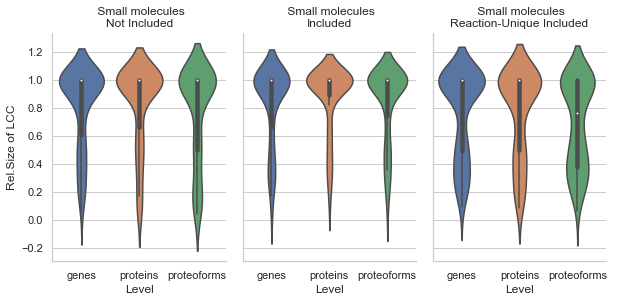

In [103]:
from config import SMALL_MOLECULES

g = sns.catplot(x="Entity Level", y='Relative size of largest connected component',
                col="Small Molecules",
                data=df_pathways.sample(1000),
                kind="violin", split=True,
                order=LEVELS, col_order=SMALL_MOLECULES,
                height=4, aspect=.7);
# g.fig.suptitle("Small Molecules")
# g.fig.subplots_adjust(top=0.85)
g.set_titles(" Small molecules\n{col_name}")
g.set_axis_labels("Level", 'Rel.Size of LCC')
g.add_legend()

c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\git\pathwayanalysisplatform\proteoformnetworks\venv\lib\site-packages\seaborn\categorical.py:2802: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


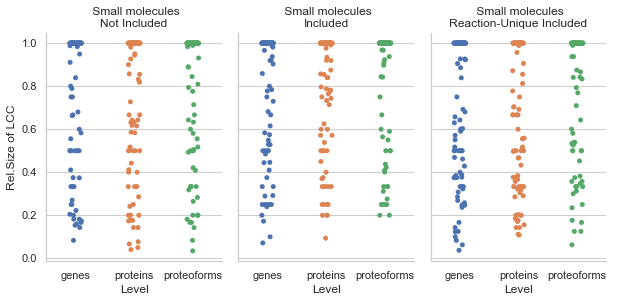

In [104]:
g = sns.catplot(x="Entity Level", y='Relative size of largest connected component',
                col="Small Molecules",
                data=df_pathways.sample(1000),
                kind="strip", split=True,
                order=LEVELS, col_order=SMALL_MOLECULES,
                height=4, aspect=.7);
# g.fig.suptitle("Small Molecules")
# g.fig.subplots_adjust(top=0.85)
g.set_titles(" Small molecules\n{col_name}")
g.set_axis_labels("Level", 'Rel.Size of LCC')
g.add_legend()